# Model recovery attack: `credit-card`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mra
from mra import *

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
min_values = df.drop(columns=["default payment next month"]).describe().transpose()['min'].to_numpy()
max_values = df.drop(columns=["default payment next month"]).describe().transpose()['max'].to_numpy()
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x-min_values)/(max_values-min_values)
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

2022-02-13 16:49:44.479514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-02-13 16:49:44.479554: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-13 16:49:44.480049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    output = tf.keras.layers.Dense(64, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

In [4]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.binary_crossentropy,
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=500
    )

Iteration 0001: Training loss: 0.6954
Iteration 0501: Training loss: 0.5167
Iteration 1001: Training loss: 0.3681
Iteration 1501: Training loss: 0.4043
Iteration 2001: Training loss: 0.4379
Iteration 2501: Training loss: 0.4907
Iteration 3001: Training loss: 0.4896
Iteration 3501: Training loss: 0.3607
Iteration 4001: Training loss: 0.3455
Iteration 4501: Training loss: 0.3473


In [5]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(512, activation=act)(xin)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(23, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [6]:
log_attack = mra.attack(
    attack_iter=100,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.2289, RG-normal: 0.2168, reconstruction validation: 0.0083
Iteration 0002: RG-uniform: 0.2321, RG-normal: 0.2071, reconstruction validation: 0.0057
Iteration 0003: RG-uniform: 0.2239, RG-normal: 0.2079, reconstruction validation: 0.0044
Iteration 0004: RG-uniform: 0.2107, RG-normal: 0.2092, reconstruction validation: 0.0049
Iteration 0005: RG-uniform: 0.2535, RG-normal: 0.2118, reconstruction validation: 0.0009
Iteration 0006: RG-uniform: 0.2230, RG-normal: 0.2080, reconstruction validation: 0.0011
Iteration 0007: RG-uniform: 0.2207, RG-normal: 0.2159, reconstruction validation: 0.0030
Iteration 0008: RG-uniform: 0.2402, RG-normal: 0.2289, reconstruction validation: 0.0031
Iteration 0009: RG-uniform: 0.2151, RG-normal: 0.2099, reconstruction validation: 0.0021
Iteration 0010: RG-uniform: 0.2343, RG-normal: 0.2129, reconstruction validation: 0.0014
Iteration 0011: RG-uniform: 0.2201, RG-normal: 0.2124, reconstruction validation: 0.0016
Iteration 0012: RG-un

In [7]:
np.savetxt("./log/credit.csv", log_attack, delimiter=",")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

log_attack = np.loadtxt("./log/credit-2.csv", delimiter=",")

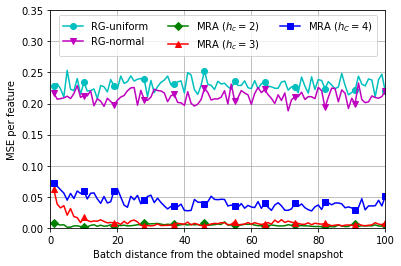

In [5]:
import numpy as np
import matplotlib.pyplot as plt

log_attack = np.loadtxt("./log/credit-2.csv", delimiter=",")
layer3 = np.loadtxt("./log/credit-3.csv", delimiter=",")[:,2]
layer4 = np.loadtxt("./log/credit-4.csv", delimiter=",")[:,2]

plt.xlim([0,100])
plt.ylim([0,0.35])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(
    ran, log_attack[:,0], 'co-',
    ran, log_attack[:,1], 'mv-',
    ran, log_attack[:,2], 'gD-',
    ran, layer3, 'r^-',
    ran, layer4, 'bs-',
    markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'MRA ($h_c=2$)', 'MRA ($h_c=3$)', 'MRA ($h_C=4$)'], loc='upper center', ncol=3)
plt.savefig("fig/credit-234.pdf", bbox_inches='tight')